# Applying variograms to gridded DEMs

**Tom Chudley | Durham University | thomas.r.chudley@durham.ac.uk**

April 2023

Here, we construct variograms from ArcticDEM strip data of Sermeq Kujalleq (Store Glacier) in West Greenland, in order to explore the length scales of crevasses. 

In [1]:
import crevdem

A number of additional packages are required to run this notebook. If you are not interested in installing them manually using `conda` or similar, you can install `crevdem` from the root directory with the `variogram` tag, e.g. `pip install .[variogram]`.

In [2]:
import json

import pdemtools as pdt
import rioxarray as rxr
import geopandas as gpd
import skgstat as skg
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from skgstat import models

# set matplotlib plotting parameters
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

## Loading the DEM and AOIs

First, we can download a clipped ArcticDEM strip of the front of Sermeq Kujalleq (Store Glacier) using `pdemtools`.

In [3]:
%%time 
bounds = (-211000, -2.138e6, -198000, -2.126e6)

gdf = pdt.search(
    dataset = 'arcticdem',
    bounds = bounds,
    dates = '20210615/20210616',
)
scene = gdf.iloc[[0]]
dem = pdt.load.from_search(scene, bounds=bounds, bitmask=True)

CPU times: user 1.65 s, sys: 522 ms, total: 2.17 s
Wall time: 51.4 s


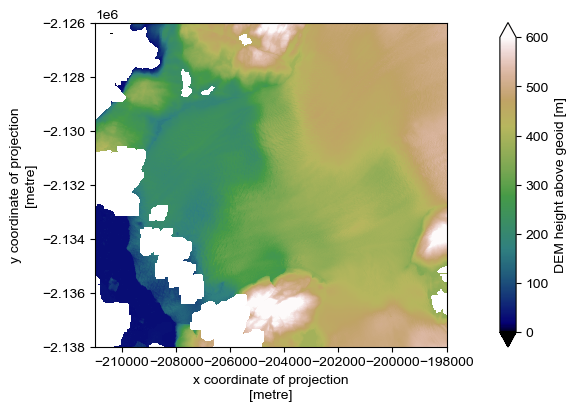

In [4]:
fig, ax = plt.subplots(figsize=(6.5,4))
dem.plot.imshow(vmin=0, vmax=600, cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'DEM height above geoid [m]'})
ax.set_aspect('equal')
ax.set_title(None)
plt.show()

In order to properly assess spatial variance on scales of interest to us, we must detrend the DEM, retaining high-frequency information.

In [5]:
dem_detrend = crevdem.detrend(dem, gauss_std_m=200)

Detrending is performed using OpenCV's `GaussianBlur` funciton. We set the standard deviation to 200 m, which performs well in seperating high- and low-frequency information on the scale of crevasses:

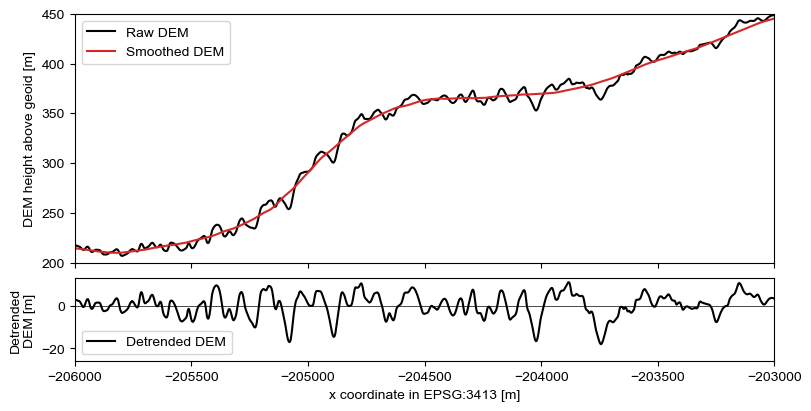

In [6]:
fig, axes = plt.subplots(nrows=2, sharex=True, height_ratios=[3,1], figsize=(8,4))

i = 2000
distance = dem.x.values

ax = axes[0]
ax.plot(distance, dem.values[i,:], c='k', label='Raw DEM')
ax.plot(distance, dem.values[i,:] - dem_detrend.values[i,:] , c='tab:red', label='Smoothed DEM')

ax.legend()
ax.set_ylabel('DEM height above geoid [m]')
ax.set_ylim(200, 450)

ax = axes[1]
ax.plot(distance, dem_detrend.values[i,:], c='k', label='Detrended DEM')
ax.legend()
ax.axhline(0, color='k', lw=.5, zorder=0)
ax.set_ylabel('Detrended\nDEM [m]')

ax.set_xlabel('x coordinate in EPSG:3413 [m]')
ax.set_xlim(-206000, -203000)
plt.show()

Variogram analysis is highly computationally intensive. Therefore, rather than sampling the entire glacier, we will subsample smaller 1.5 km<sup>2</sup> regions. To differentiate them, we will assign them an arbritary and qualitative measure of the amount of crevassing, which we label `intensity`.

Here, we create a GeoPandas GeoDataFrame of our regions from a pre-made GeoJSON string:

In [7]:
regions_geojson_string = '{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"intensity": 2}, "geometry": {"type": "Polygon", "coordinates": [[[-198327.05677448877, -2132380.479004478], [-199827.05677448877, -2132380.479004478], [-199827.05677448877, -2130880.479004478], [-198327.05677448877, -2130880.479004478], [-198327.05677448877, -2132380.479004478], [-198327.05677448877, -2132389.021112459], [-198327.05677448877, -2132380.479004478]]]}}, {"id": "1", "type": "Feature", "properties": {"intensity": 3}, "geometry": {"type": "Polygon", "coordinates": [[[-203467.40139216662, -2130925.2526287767], [-204967.40139216662, -2130925.2526287767], [-204967.40139216662, -2129425.2526287767], [-203467.40139216662, -2129425.2526287767], [-203467.40139216662, -2130925.2526287767], [-203467.40139216662, -2130933.7947367574], [-203467.40139216662, -2130925.2526287767]]]}}, {"id": "2", "type": "Feature", "properties": {"intensity": 0}, "geometry": {"type": "Polygon", "coordinates": [[[-200872.6597127783, -2137523.3506744555], [-202372.6597127783, -2137523.3506744555], [-202372.6597127783, -2136023.3506744555], [-200872.6597127783, -2136023.3506744555], [-200872.6597127783, -2137523.3506744555], [-200872.6597127783, -2137531.892782436], [-200872.6597127783, -2137523.3506744555]]]}}, {"id": "3", "type": "Feature", "properties": {"intensity": 4}, "geometry": {"type": "Polygon", "coordinates": [[[-205264.24171962458, -2133407.3256572867], [-206764.24171962458, -2133407.3256572867], [-206764.24171962458, -2131907.3256572867], [-205264.24171962458, -2131907.3256572867], [-205264.24171962458, -2133407.3256572867], [-205264.24171962458, -2133415.8677652674], [-205264.24171962458, -2133407.3256572867]]]}}, {"id": "4", "type": "Feature", "properties": {"intensity": 1}, "geometry": {"type": "Polygon", "coordinates": [[[-200177.78273851526, -2128740.717941893], [-201677.78273851526, -2128740.717941893], [-201677.78273851526, -2127240.717941893], [-200177.78273851526, -2127240.717941893], [-200177.78273851526, -2128740.717941893], [-200177.78273851526, -2128749.2600498735], [-200177.78273851526, -2128740.717941893]]]}}]}'
regions_geojson = json.loads(regions_geojson_string)
regions = gpd.GeoDataFrame.from_features(regions_geojson['features'], crs=3413)

Let's plot the sample regions over the DEM.

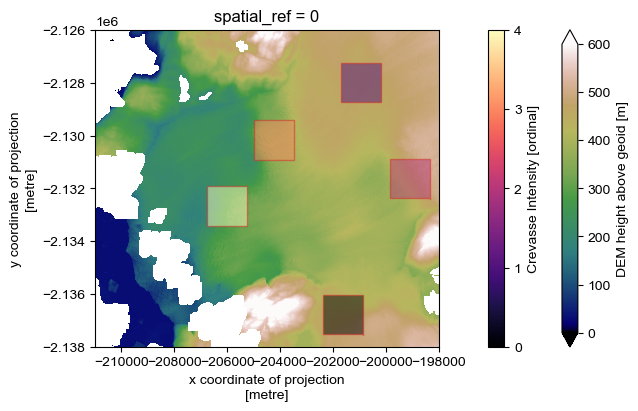

In [8]:
fig, ax = plt.subplots(figsize=(6.5,4))

dem.plot.imshow(vmin=0, vmax=600, cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'DEM height above geoid [m]'})

regions.plot(
    ax=ax, column='intensity', cmap='magma', 
    ec='tab:red', alpha=.5, legend=True, 
    legend_kwds={'label': 'Crevasse Intensity [ordinal]', 'ticks': [0,1,2,3,4], 'format': '%d'}
)
plt.show()

## Prepping the data for variograms

Here, we set up a series of functions so that, for each sample zone, we:

 - Clip the detrended DEM dataset to the sample zone AOI.
 - Convert the array into a Pandas datafram with `x`, `y`, and `z` columns.
 - Randomly subsample 2% of the full array (processing increases exponentially with the number of the points, but is very robust to subsampling).

The output of these functions is a dictionary of the relevant variables for processing, most relevant being the dataframe.


In [9]:
def df_from_xds(xds):

    X, Y = np.meshgrid(xds.x, xds.y)
    df = pd.DataFrame({'x': X.ravel(), 'y': Y.ravel(), 'z':xds.values.ravel()})
    return df.astype('float32')  # convert to float32 for speed

def get_dem_df(xds, regions, intensity, sample_frac=0.02):
    
    bounds = regions[regions['intensity']==intensity].total_bounds
    clip_xds = xds.rio.clip_box(*bounds)
    
    df = df_from_xds(clip_xds)
    df = df.sample(frac=sample_frac)
        
    return {
        'intensity': intensity, 'grid': clip_xds.values, 
        'x':clip_xds.x.values, 'y':clip_xds.y.values, 'bounds': bounds, 'df': df
    }

We loop through all of the sample regions, performing this operation on all of them:

In [10]:
samples = [get_dem_df(dem_detrend, regions, i, 0.02) for i in [0,1,2,3,4]]

## Computing the variograms

We can now create a function to compute the variogram from the detrended data. We use a `maxlag` of 200 m.

In [11]:
def compute_variogram(
    df, 
    maxlag=200,   # maximum range distance
    n_lags = 100   # number of bins
):
    """
    compute experimental (isotropic) variogram
    """
    
    coords = df[['x','y']].values
    values = df['z']

    # compute variogram
    V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

    return V1

We loop through the sample areas, computing the variogram for each and adding at as a `variogram` key in the dictionary.

In [12]:
for s in samples:
    print(f'{s["intensity"]}... ', end='')
    s['variogram'] = compute_variogram(s['df'])
print('Finished.')

0... 1... 2... 3... 4... Finished.


# Plotting the variograms

And we can now plot the experimental and model variograms. We fit a gaussian model, which appears to match the crevassed topography best. We also visualise the `range` parameter as a vertical dashed line.

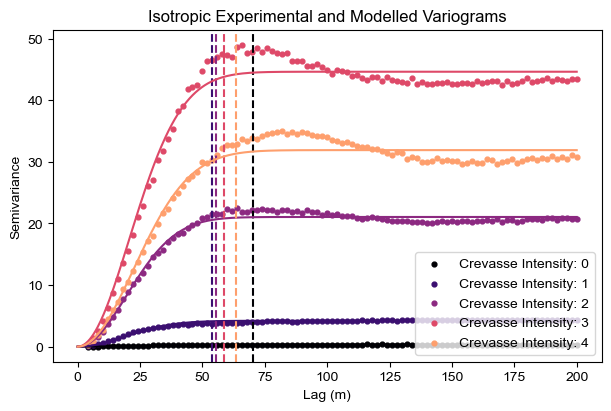

In [13]:
fig, ax = plt.subplots(figsize=(6,4))

def plot_variogram(variogram, colour, label):
    
    # plot experimental
    xdata = variogram.bins
    ydata = variogram.experimental
    ax.scatter(xdata, ydata, s=12, c=colour, label=label)

    # plot model
    variogram.model='gaussian'
    vrange, vsill, vnugget = variogram.parameters
    xi = np.linspace(0, xdata[-1], 500) 
    y_exp = [models.gaussian(h, vrange, vsill, vnugget) for h in xi]
    plt.plot(xi, y_exp,'-', color=c[0])
    plt.axvline(vrange, c=c[0], ls='--')

color = iter(plt.cm.magma(np.linspace(0, 1, 6)))

for s in samples:
    c = [next(color)]
    plot_variogram(s['variogram'], c, f'Crevasse Intensity: {s["intensity"]}')

ax.legend(loc='lower right')
plt.title('Isotropic Experimental and Modelled Variograms')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

Crevassed regions have a cluster of ranges between 50-70 m, suggesting that this would be a good size for our structuring element used in the downstream processes. This range clustering remains true across a number of Greenlandic outlet glaciers that have been tested, leading to 60 m being determined as the default `crevdem` range with the widest generic applicability.

Note that a range size of ~60 m can be interpreted as the statistically most likely distance between the crevasse edges and the crevasse bottoms (i.e. the largest vertical variance). The statistically dominant 'diameter' of crevasses is thus ~120 m. We use 60 m as our input in `crevdem` as the receptive range of a BTH filter (which consists of two kernel passes, an erosion and a dilation) is 120 m.